A notebook to play around with the [did](https://github.com/bcallaway11/did) package by Brantly Callaway and Pedro H.C. Sant’Anna. See the vignette [Getting Started with the did Package](https://cran.r-project.org/web/packages/did/vignettes/did-basics.html).
 
**Technical details**

Used conda environment is `dev2023a` from [here](https://github.com/vvoutilainen/dsenvs/blob/main/condaenv.md). The *did* package was installed as follows:

 - First, installed *r-ggpubr* into `dev2023a` with conda/mamba. This also downloaded and installed *r-pbkrtest*, *r-car*, and *r-rstatix*.
 - Next, *did* was installed using R's `install.packages()` command with `dependencies=TRUE`. This also installed some additional packages (e.g., *trust*, *BMisc*, *pbapply* , and *DRDID*).

# Imports and auxiliary functions

In [1]:
%%capture
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from IPython.display import display, Math
import rpy2
%load_ext rpy2.ipython

from did_helpers import(
    simulate_did_data,
    plot_repcrossec_data,
    parallel_trends_plot,
    dynamic_did_plot,
)

In [2]:
%%R
library(did)
set.seed(1814)

In [3]:
def plot_group_means(df):
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(1, 1, 1)
    _ = df.groupby([
        "G",
        "period",
    ]).agg({"Y": "mean"}).reset_index().pivot_table(
        values="Y",
        index="period",
        columns="G"
    ).plot(
        style='.--',
        ax=ax,
    )

def plot_group_cluster_means(df):
    fig = plt.figure(figsize=(8, 4))
    for counter, g in enumerate(df["G"].unique()):
        ax = fig.add_subplot(2, 2, counter+1)
        df.query("G=={}".format(g)).groupby([
            "cluster",
            "period",
        ]).agg({"Y": "mean"}).reset_index().pivot_table(
            values="Y",
            index="period",
            columns="cluster"
        ).plot(
            style='.--',
            legend=False,
            linewidth=0.5,
            markersize=2,
            ax=ax,
        )
        ax.set_title("G = {}".format(g))
    fig.tight_layout()
    
def prepare_dynamic_regression_frame(data):

    df = data["observed"].copy()
    param_last_pre_timepoint = data["params"]["param_last_pre_timepoint"]
    
    # Variable measuring periods to first treatment time 
    df["time_to_treat"] = (
        df["t"]
        .sub(param_last_pre_timepoint+1)
        .astype('int')
    )

    # We want to create "treatment" dummies from the time_to_treat column such that the kth dummy
    # obtains value 1 for a given observation if the period of the observation equals k.

    # To this end, first set time_to_treat cor control observations to 0, as the treatment
    # dummy values need to be zero for them.
    df.loc[df["treatment_group"]=="control", "time_to_treat"] = 0

    # Now create the "dynamic" dummies from time_to_treat. Drop out the last time point before treatment
    # manually to avoid multicolinearity problems (this sets the last time point before treatment as a
    # reference) point.
    df = (
        pd.get_dummies(
            df,
            columns=["time_to_treat"],
            prefix="dummy_group_x_period",
            drop_first=False
        )
        .rename(columns=lambda x: x.replace('-', 'm'))
        .drop(columns="dummy_group_x_period_m1")
    )

    # Time points as categorical/str
    df["t"] = df["t"].astype(str)

    return df

# Panel data

## Example from the vignette

Let's replicate the simulated data example from the vignette [Getting Started with the did Package](https://cran.r-project.org/web/packages/did/vignettes/did-basics.html).

### Simulate data

First, simulate the data (we adapt the notation from my own notebook *did_simulated_datasets.ipynb*): the data-generating process (DGP) for the untreated potential outcome of individual $i$ in group $j$ is given by

\begin{align*}
Y_{ijt}^0 = \gamma_j + \xi_t + \lambda_t X_{ij} + \epsilon_{it}
\end{align*}

That is,

 - there are group and time fixed-effects, which justifies the use of a DiD model (a simple comparion of outcomes in levels between treated and untreated would not deliver an average treatment effect);
 - there are group-specific, time-invariant covariates with time-variant (and group-invariant) effects that affect the untreated potential outcome (which are set such that unconditional parallel trends does not indeed hold; see the vignette). Due to the time-variant effects, controlling for the covariate needs to be of the type `X * time` (see [here](https://diff.healthpolicydatascience.org/)).
 
This setup for the untreated potential outcomes essentially corresponds to simulation *4b* in [Zeldow & Hatfield (2021)](https://onlinelibrary.wiley.com/doi/10.1111/1475-6773.13666), the main difference being, of course, that here we have multiple groups due to the staggered treatment adoption.

The treated potential outcomes are modelled as

\begin{align*}
Y_{ijt}^1 = Y_{ijt}^0 + \tau_{jt} + (v_{it} - \epsilon_{it})
\end{align*}

where

 - $\tau_{jt} = \tau \ \big(  t-g(j) \big) \ \unicode{x1D7D9}_{t>g}$ with $\tau = 1$;
 - $g(j)$ is the last pre-treatment period time point for group $j$.
 
The simulated data will have four groups: group 0 does not get treatment at all, whereas groups $j = \{ 2, 3, 4 \}$ are treated at time points $g(j) = j$. 

In [4]:
%%R -o dta,sp
sp = reset.sim()
time_periods = 4
sp$te.e <- 1:time_periods
dta = build_sim_dataset(sp)

In [5]:
# Print parametes
display(Math(
    "\\text{{Evolution of }} \lambda_t: {}".format(
        sp["bett"].tolist()
    )
))
print("True treatment effects per time points exposed to treatment {}".format(
    [t for t in range(1, int(sp["time.periods"][0] + 1))]
))

<IPython.core.display.Math object>

True treatment effects per time points exposed to treatment [1, 2, 3, 4]


Plot the mean values of the response variable per group at each time point.

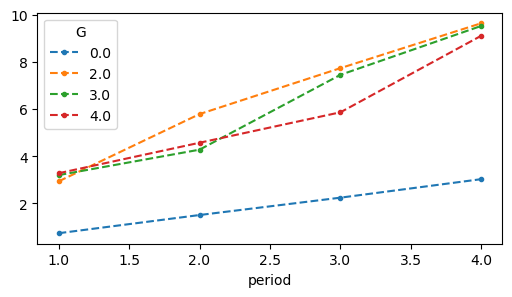

In [6]:
plot_group_means(dta)

Plot the mean values of the response variable per group-cluster at each time point.

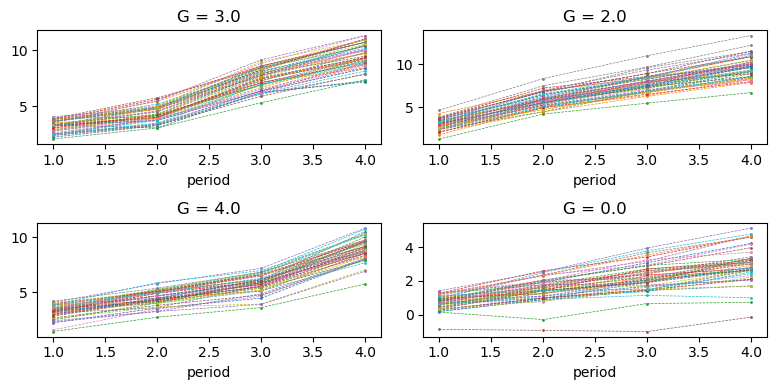

In [7]:
plot_group_cluster_means(dta)

### Regressions, control group never treated

Let's run the first regression, using only the never-treated units as the control group. As per [documentation](https://cran.r-project.org/web/packages/did/did.pdf), function `att_gt` "*computes average treatment effects in DID setups where there are more than two periods of data and allowing for treatment to occur at different points in time and allowing for treatment effect heterogeneity and dynamics"*.

That is, we obtain estimates for each post-period time point as well as "pseudo-ATT" estimates for the pre-treatment periods.


Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    xformla = ~X, data = dta, control_group = "nevertreated")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
     2    2   1.9209     0.0618        1.7523      2.0896 *
     2    3   2.9875     0.0676        2.8029      3.1720 *
     2    4   3.9552     0.0626        3.7845      4.1259 *
     3    2  -0.0433     0.0634       -0.2163      0.1297  
     3    3   2.1080     0.0675        1.9239      2.2922 *
     3    4   3.0590     0.0649        2.8820      3.2360 *
     4    2   0.0023     0.0643       -0.1732      0.1779  
     4    3   0.0615     0.0651       -0.1162      0.2393  
     4    4   1.9523     0

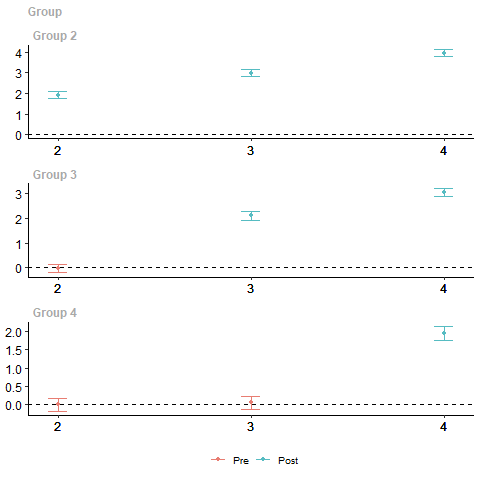

In [8]:
%%R
out = att_gt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla=~X,
    control_group="nevertreated",
    data=dta
)
summary(out)

# Plot results
ggdid(out)

There are multiple ways to aggregate the results to obtain more easily interpretable results:

 1. Over groups: this is analogous to a "dynamic" two-group DiD;
 2. Over time: this gives the average treatment effect per group;
 3. Over groups and time: this is analogous to a "static" two-group DiD.
 
Let's perform the aggregations and display the results.

#### Aggregate over groups


Call:
aggte(MP = out, type = "dynamic")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on event-study/dynamic aggregation:  
    ATT    Std. Error     [ 95%  Conf. Int.]  
 2.9904        0.0372     2.9174      3.0634 *


Dynamic Effects:
 Event time Estimate Std. Error [95% Simult.  Conf. Band]  
         -2   0.0023     0.0698       -0.1741      0.1788  
         -1   0.0105     0.0409       -0.0930      0.1140  
          0   1.9929     0.0290        1.9194      2.0663 *
          1   3.0231     0.0445        2.9107      3.1356 *
          2   3.9552     0.0606        3.8018      4.1086 *
---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust


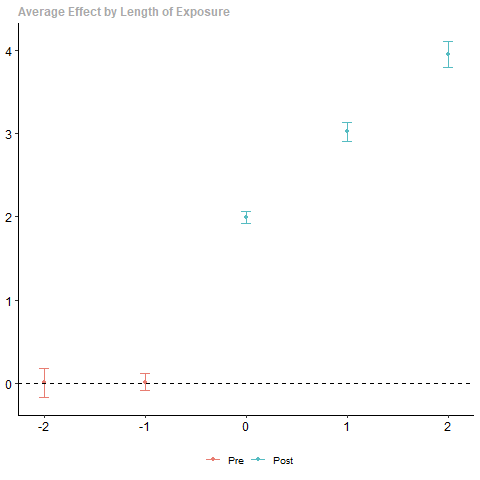

In [9]:
%%R
agg_out = aggte(out, type="dynamic")
summary(agg_out)
ggdid(agg_out)

#### Aggregate over time


Call:
aggte(MP = out, type = "group")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on group/cohort aggregation:  
   ATT    Std. Error     [ 95%  Conf. Int.]  
 2.488        0.0341     2.4213      2.5548 *


Group Effects:
 Group Estimate Std. Error [95% Simult.  Conf. Band]  
     2   2.9545     0.0507        2.8333      3.0757 *
     3   2.5835     0.0564        2.4486      2.7185 *
     4   1.9523     0.0664        1.7935      2.1111 *
---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust


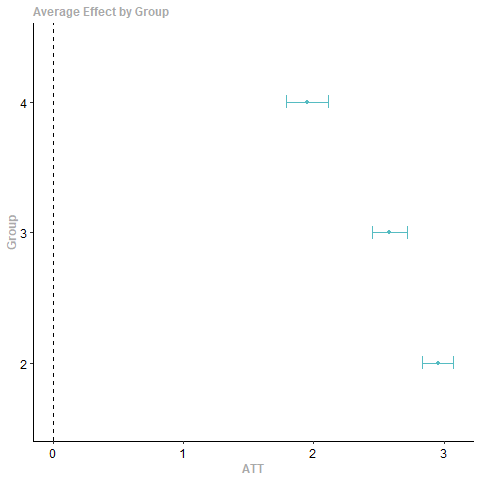

In [10]:
%%R
agg_out = aggte(out, type="group")
summary(agg_out)
ggdid(agg_out)

#### Aggregate over groups and time

In [11]:
%%R
agg_out = aggte(out, type="simple")
summary(agg_out)


Call:
aggte(MP = out, type = "simple")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


    ATT    Std. Error     [ 95%  Conf. Int.]  
 2.6583        0.0318     2.5959      2.7207 *


---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust


### Regressions, control group not-yet-treated

Similar to the previous case, but now we extend the control group to also cover not-yet-treated observations. To save space, we only run the main regressions and the aggregation over groups and time. The main aggregated result differs slightly compared to the above case.

In [12]:
%%R
out = att_gt(
    yname="Y",
    tname="period",
    idname="id",
    gname="G",
    xformla=~X,
    control_group="notyettreated",
    data=dta
)
summary(out)

# Plot results
ggdid(out)

# Aggregate over
agg_out = aggte(out, type="simple")
summary(agg_out)


Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    xformla = ~X, data = dta, control_group = "notyettreated")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
     2    2   1.9371     0.0539        1.7913      2.0828 *
     2    3   2.9612     0.0573        2.8063      3.1162 *
     2    4   3.9552     0.0668        3.7744      4.1360 *
     3    2  -0.0393     0.0568       -0.1929      0.1144  
     3    3   2.0747     0.0536        1.9296      2.2198 *
     3    4   3.0590     0.0618        2.8919      3.2261 *
     4    2   0.0207     0.0584       -0.1372      0.1786  
     4    3   0.0615     0.0663       -0.1177      0.2408  
     4    4   1.9523     

## Example with vanilla panel model: two-groups, two-periods

The idea here is to simulate data with minimal effects and check that we obtain the expected estimates with the *did* package.

The untreated potential outcomes are given by

\begin{align*}
Y_{ijt}^0 = \gamma_j + \epsilon_{it}
\end{align*}

and the treated potential outcomes by

\begin{align*}
Y_{ijt}^1 = Y_{ijt}^0 + \tau_{jt} + (v_{it} - \epsilon_{it}),
\end{align*}

where

 - $\tau_{jt} = -1$ when $j=2, t=2$ (treated group at time $2$), and zero otherwise.
 
Now simulate data using the *did* package:

In [13]:
%%R -o dta
sp = reset.sim(time.periods=2)
sp$thet = rep(0, sp$time.periods)
sp$theu = rep(0, sp$time.periods)
sp$bett = rep(0, sp$time.periods)
sp$betu = rep(0, sp$time.periods)
sp$te.bet.ind = rep(0, sp$time.periods)
sp$te.bet.X = rep(0, sp$time.periods)
sp$te.t = rep(0, sp$time.periods)
sp$te = 0
dta = build_sim_dataset(sp)

Plot group means for the response variable.

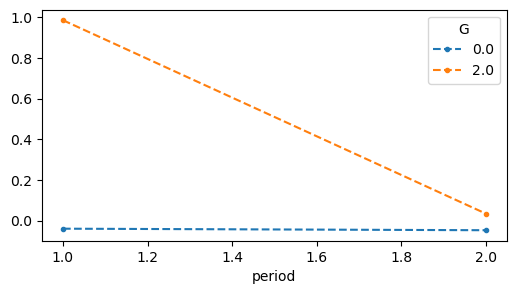

In [14]:
plot_group_means(dta)

Run vanilla DiD regressions using *statsmodels*.

In [15]:
# Format data a bit
dta["period_dummy"] = np.where(dta["period"] < 2, 0, 1)
dta["periodxtreatment_dummy"] = dta["period_dummy"] * dta["treat"]

# Run the regression
reg_str = "Y ~ 1 + treat + period_dummy + periodxtreatment_dummy"
res = smf.ols(reg_str, data=dta).fit(
    cov_type="cluster",
    cov_kwds={
        "groups": dta["id"],
        "use_correction": False,
    }
)
print("Regression: {}\n".format(reg_str))
print(res.summary())

Regression: Y ~ 1 + treat + period_dummy + periodxtreatment_dummy

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     161.4
Date:                Sat, 06 Jan 2024   Prob (F-statistic):           1.05e-97
Time:                        15:01:08   Log-Likelihood:                -11774.
No. Observations:                6692   AIC:                         2.356e+04
Df Residuals:                    6688   BIC:                         2.358e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

Next, run the same regression using the *did* package. We obtain the same result as with *statsmodels*.

In [16]:
%%R -i dta
# Warning relates to Wald pre-treatment period test 
out = att_gt(
    yname="Y",
    tname="period",,
    idname="id",
    gname="G",
    bstrap=F,
    panel=T,
    data=dta,
)
summary(out)

R[write to console]: No pre-treatment periods to test




Call:
att_gt(yname = "Y", tname = "period", idname = "id", gname = "G", 
    data = dta, panel = T, bstrap = F)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Pointwise  Conf. Band]  
     2    2  -0.9419     0.0584         -1.0564     -0.8274 *
---
Signif. codes: `*' confidence band does not cover 0

Control Group:  Never Treated,  Anticipation Periods:  0
Estimation Method:  Doubly Robust


# Repeated cross-section

## Example with multi-period, two-group case

The idea here is to test the *did* package results against a "dynamic" DiD model with two groups.

Simulate data such that the treatment effect at post-period time points is $[-2, -4, -6]$.

In [17]:
data_1 = simulate_did_data(
    param_datasettype="repeated cross-section",
    param_gamma_c=4,
    param_gamma_t=1,
    param_no_t=6,
    param_treat_eff_trend=True,
)

Plot the data.

Realized control pre-period mean 5.028
Realized control post-period mean 7.968
Realized treated pre-period mean 2.021
Realized treated post-period mean 1.016
Counterfactual (unobserved) treatment post-period mean 5.016
Counterfactual (naively estimated) treated post-period mean 4.961
Naive DiD-estimate -3.945


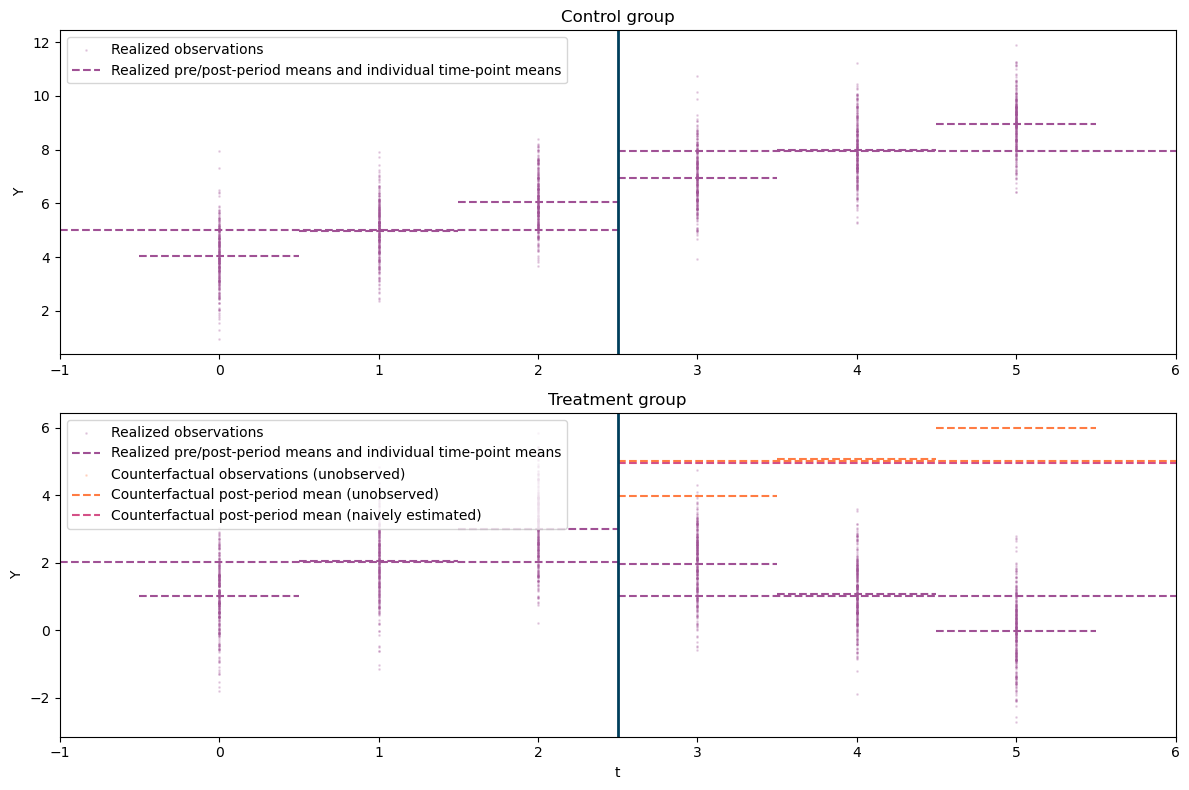

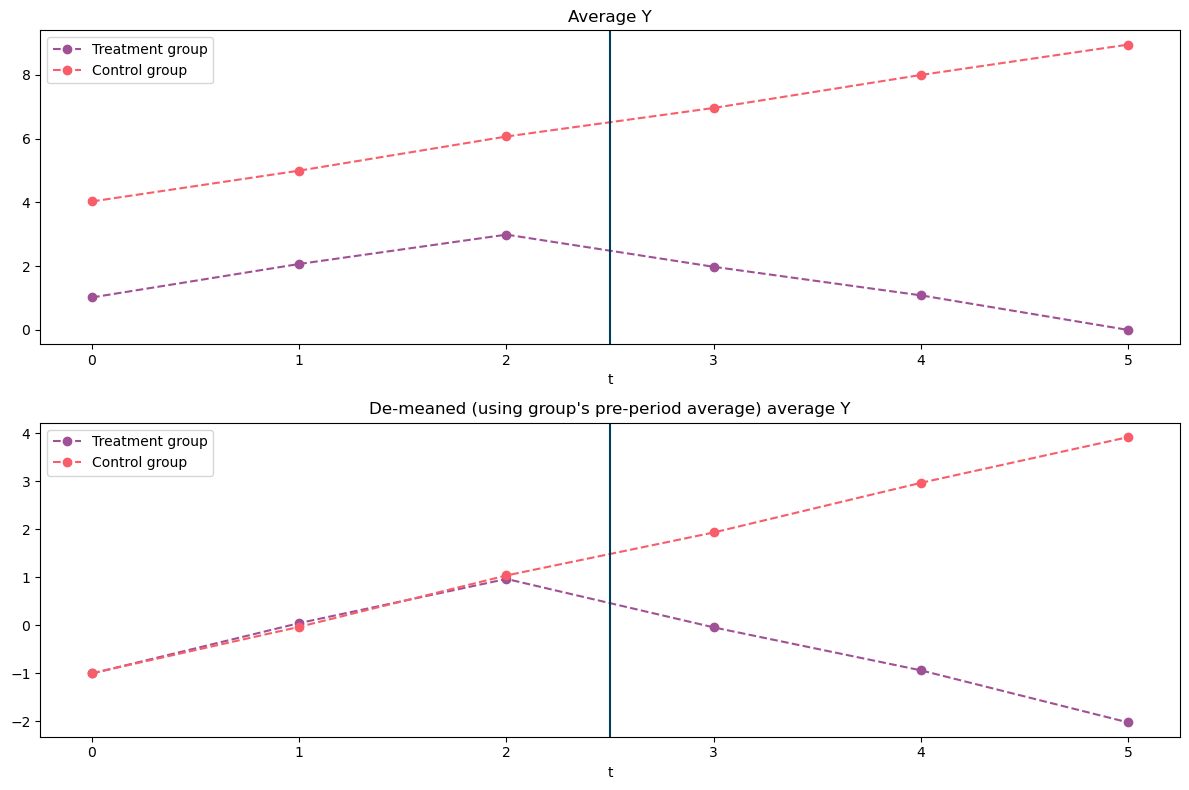

In [18]:
plot_repcrossec_data(data_1, figsize=(12, 8), legendloc="upper left")
parallel_trends_plot(data_1, figsize=(12, 8))

Now we run the dynamic DiD model using *statsmodels*.

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     2628.
Date:                Sat, 06 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:01:09   Log-Likelihood:                -5100.3
No. Observations:                3600   AIC:                         1.022e+04
Df Residuals:                    3588   BIC:                         1.030e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
treatment_group[cont

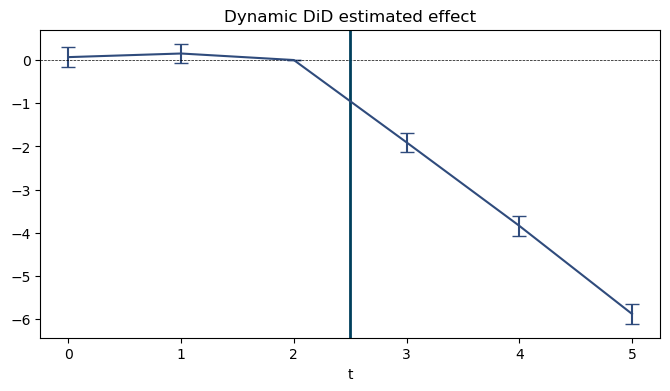

In [19]:
df = prepare_dynamic_regression_frame(data_1)
reg_str = "Y ~ -1 + treatment_group + t + " + " + ".join(df.columns[df.columns.str.contains("dummy_group_x_period")])
res = smf.ols(reg_str, data=df).fit()
print(res.summary())
dynamic_did_plot(
    res,
    data_1["params"]["param_last_pre_timepoint"]
)

Next, we run the DiD model using the *did* package. We set `base_period` to "*universal*". This corresponds to the last pre-treatment time point being the one we normalize against, as typically is the convention in "dynamic" DiD specifications (see [documentation](https://cran.r-project.org/web/packages/did/did.pdf) p. 10).

We see that the coefficient estimates coincide between the usual "dynamic" DiD and the *did* package ones. Also, the aggregate coefficient estimate agrees. Standard errors are not quite the same; above we have not paid attention to the calculation of standard errors. 

In [20]:
# Prepare data for r-did
df = prepare_dynamic_regression_frame(data_1)
df["t"] = (df["t"].astype(int) + 1).astype("object")
df["t_num"] = df["t"].copy().astype(float)
df["tc_group_num"] = df["treatment_group"].copy().map({
    "control": 0,
    "treatment": int(data_1["params"]["param_no_t"] / 2) + 1
})


Call:
att_gt(yname = "Y", tname = "t_num", gname = "tc_group_num", 
    data = df, panel = F, bstrap = F, base_period = "universal")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Pointwise  Conf. Band]  
     4    1   0.0676     0.1149         -0.1577      0.2928  
     4    2   0.1511     0.1166         -0.0775      0.3798  
     4    3   0.0000         NA              NA          NA  
     4    4  -1.9054     0.1154         -2.1316     -1.6792 *
     4    5  -3.8362     0.1154         -4.0625     -3.6100 *
     4    6  -5.8751     0.1142         -6.0991     -5.6512 *
---
Signif. codes: `*' confidence band does not cover 0

P-value for pre-test of parallel trends assumption:  0.43105
Control Group:  

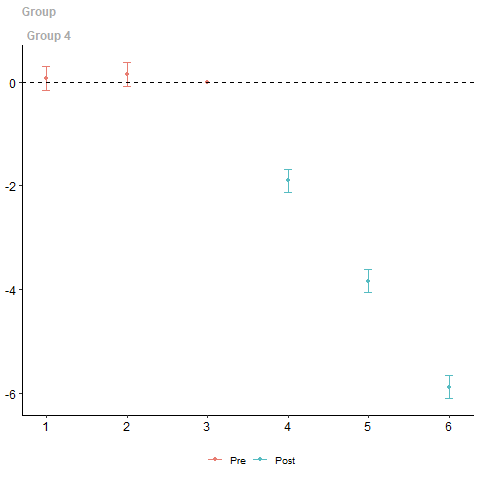

In [21]:
%%R -i df
out = att_gt(
    yname="Y",
    tname="t_num",
    gname="tc_group_num",
    bstrap=F,
    panel=F,
    base_period="universal",
    data=df,
)
agg_simple = aggte(out, type="simple")

# Summary of main regression
summary(out)

# Aggregated result
summary(agg_simple)

# Plot results
ggdid(out)